<a href="https://colab.research.google.com/github/Kashika18/Breast_Cancer_Prediction/blob/main/ddsm_pre_trained_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.metrics import categorical_crossentropy

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Dense,Flatten,Dropout,Activation,BatchNormalization,AvgPool2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
import cv2 

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions,ResNet50
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
train_data='/content/drive/MyDrive/ddsm dataset split/train'
test_data='/content/drive/MyDrive/ddsm dataset split/test'
valid_data='/content/drive/MyDrive/ddsm dataset split/val'

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range = 0.2, zoom_range = 0.2, 
                                   horizontal_flip = True,validation_split=0.4)

train_generator = train_datagen.flow_from_directory(train_data,
                                              target_size = (224,224), batch_size = 512, 
                                              class_mode = 'categorical',subset='training', shuffle = True)

val_generator = train_datagen.flow_from_directory(valid_data,
                                              target_size = (224,224), batch_size = 512, 
                                              class_mode = 'categorical',subset='validation')


Found 2277 images belonging to 2 classes.
Found 520 images belonging to 2 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory(test_data,
                                              target_size = (224,224), batch_size = 1, 
                                              class_mode = 'categorical',subset='validation', shuffle = True)


Found 506 images belonging to 2 classes.


In [ ]:
x,y=test_generator.next()
x.shape

(1, 224, 224, 3)

In [ ]:
base_model = ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)



94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [ ]:
from PIL import Image


# import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/projet dataset split/test/cancer/10260_idx5_x1201_y1151_class1.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = model.predict(input_data)
if pred.all() >= 0.5:
  print("Yes")
else:
  print("No")

Yes


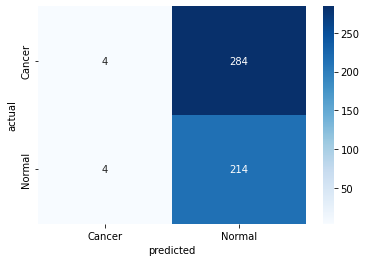

test_accuracy : 43.08300395256917 


In [ ]:
import seaborn as sns

filenames=test_generator.filenames
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for i in range(nb_samples):
  X_test,Y_test=test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix=pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['actual'],colnames=['predicted'])

sns.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()
print('test_accuracy : {} '.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))
